## The Prediction of Nuclear Magnetic Resonance Spectroscopy

In this tutorial, we showcase the simulation of Nuclear Magnetic Resonance (NMR) Spectroscopy of organic molecules as an application of quantum computers using qiskit. In the NMR experiment, a magnetic field is applied to the sample, which polarizes the nuclear spins and in turn reveals the internal struqture of the molecule.

This notebook implements the calculation that has been discussed in detail in the papers ([Nature Machine Intelligence 2, 396 (2020)](https://www.nature.com/articles/s42256-020-0198-x)) by Sels et al. and  ([arXiv:2404.18903](https://arxiv.org/abs/2404.18903)) by [HQS Quantum Simulations](quantumsimulations.de). 


We start by importing relevant libraries.

In [1]:
import qiskit
import json
from qiskit_ibm_runtime import Estimator
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.quantum_info.operators import SparsePauliOp

from struqture_py.spins import PauliHamiltonian

We next specify the relevant parameters of the trotterized time evolutions:

In [2]:
number_of_trottersteps = 400
number_spins = 2
number_shots = 1000
trotter_timestep = 0.01

### Step 1: Define the Hamiltonian

This notebook loads the Hamiltonian of `cis-3-chloroacrylic acid` at the magnetic field of 11.7 Tesla in $x$ direction from a json file, written in `struqture_py`. You can find the user documentation here: https://hqsquantumsimulations.github.io/struqture/

In [3]:
with open("hamiltonian_cis_3_chloroacrylic_acid_B=11.7_Tesla.json", "r") as json_file:
    hamiltonian_json = json.load(json_file)

system_hamiltonian = PauliHamiltonian.from_json(hamiltonian_json)

system_hamiltonian

PauliHamiltonian{
0X1X: 1.244070690821558e1,
0Y1Y: 1.244070690821558e1,
1X: 5.712266230583191e1,
0X: -5.712266254425049e1,
0Z1Z: 1.244070690821558e1,
}

In the presence of a static magnetic field $\vec{B}$, the spin Hamiltonian of a given molecule in the liquid phase reads

$$H = -\gamma \sum_{i=1}^N (1+\delta_i) {\vec{S}_{i}} \cdot \vec{B} +  \sum_{i,j=1}^N\sum_{j>i} J_{ij}  \vec{S}_{i} \cdot \vec{S}_{j} ~, $$

where $\gamma$ is the gyromagnetic ratio, $N$ the total number of spins, $\delta_i$ encodes the chemical shifts caused by electrons shielding the magnetic field,
$\vec{S}$ represents the nuclear spin, and $J_{ij}$ determines the strength of the interaction between $i$-th and $j$-th nuclear spins. Note that in the liquid phase, the Hamiltonian has the SU(2) symmetry. Here we assume the magnetic field to be in $x$ direction.

We can use the following function to define the Hamiltonian in `qiskit` from the `struqture_py` one.

In [4]:
from qiskit.quantum_info.operators import SparsePauliOp
from struqture_py.spins import PauliHamiltonian


def struqture_hamiltonian_to_qiskit_op(
    ham_struqture: PauliHamiltonian, n_qubits: int
) -> SparsePauliOp:
    """Converts struqture-style Pauli strings ("iXjZ") to Qiskit format ("XZ",[i,j]).

    Args:
        struqture_input: String or list of strings in struqture format.
        n_qubits: Total number of qubits.

    Returns:
        Qiskit-style Pauli string or list of such strings.
    """

    def convert_single(s: str) -> str:
        pauli_vec = ["I"] * n_qubits
        if s != "I":
            for i in range(0, len(s), 2):
                idx = int(s[i])
                op = s[i + 1]
                pauli_vec[n_qubits - idx - 1] = op
        return "".join(pauli_vec)

    pauli_strs = []
    coeffs = []
    for key, val in zip(ham_struqture.keys(), ham_struqture.values()):
        s = str(key)
        p = convert_single(s)
        pauli_strs.append(p)
        coeffs.append(complex(val))

    return SparsePauliOp(pauli_strs, coeffs)

In [5]:
H = struqture_hamiltonian_to_qiskit_op(system_hamiltonian, 2)

H

SparsePauliOp(['XX', 'YY', 'XI', 'IX', 'ZZ'],
              coeffs=[ 12.44070691+0.j,  12.44070691+0.j,  57.12266231+0.j, -57.12266254+0.j,
  12.44070691+0.j])

We define the relevant operators, namly the total magnetization in z and y direction.

In [6]:
Magnetization_z = SparsePauliOp.from_sparse_list(
    [("Z", [0], 1.0)], num_qubits=number_spins
)

for i in range(1, number_spins):
    Magnetization_z += SparsePauliOp.from_sparse_list(
        [("Z", [i], 1.0)], num_qubits=number_spins
    )

Magnetization_y = SparsePauliOp.from_sparse_list(
    [("Y", [0], 1.0)], num_qubits=number_spins
)

for i in range(1, number_spins):
    Magnetization_y += SparsePauliOp.from_sparse_list(
        [("Y", [i], 1.0)], num_qubits=number_spins
    )

### Step 2: Find Quantum Circuit of Trotterized Time-Evolution

Assuming that the magnetic field is applied in x direction, the NMR spectrum is obtained from the Fourier transform of the following:

$$ \langle S^{z/y}_{\rm tot}(t)S^z_{\rm tot}(0)\rangle = \text{Tr} \{ e^{iHt}S^{z/y}_{\rm tot} e^{-iHt} S^z_{\rm tot} \} ~,$$
which by introducing the eigenstates of $S^z_{\rm tot}| m_n\rangle=m_n| m_n\rangle$ can be rewritten as

$$ \langle S^{z/y}_{\rm tot}(t)S^z_{\rm tot}(0)\rangle = \sum_{m_n(0)>0} m_n (0) \langle m_n(t)|S^{z/y}_{\rm tot}| m_n(t)\rangle ~,$$

where the sum is over all initial states resulting is positive total magnetization. In the current example for 2 spins, we only have one relevant initial state. For bigger molecules, see 'HQS Qorrelator App' from ([HQStage](https://docs.cloud.quantumsimulations.de)).

We therefore find the quantum circuit corresponding to a trotterized time evolution.

In [7]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

trotter_step_first_order = PauliEvolutionGate(
    H, trotter_timestep, synthesis=LieTrotter()
)

# We create an empty circuit
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_first_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

print(circuit)

     ┌───┐                         ┌───┐┌──────┐                         ┌────┐»
q_0: ┤ H ├──■───────────────────■──┤ H ├┤ √Xdg ├──■───────────────────■──┤ √X ├»
     ├───┤┌─┴─┐┌─────────────┐┌─┴─┐├───┤├──────┤┌─┴─┐┌─────────────┐┌─┴─┐├────┤»
q_1: ┤ H ├┤ X ├┤ Rz(0.24881) ├┤ X ├┤ H ├┤ √Xdg ├┤ X ├┤ Rz(0.24881) ├┤ X ├┤ √X ├»
     └───┘└───┘└─────────────┘└───┘└───┘└──────┘└───┘└─────────────┘└───┘└────┘»
«     ┌──────────────┐                         
«q_0: ┤ R(-1.1425,0) ├──■───────────────────■──
«     ├─────────────┬┘┌─┴─┐┌─────────────┐┌─┴─┐
«q_1: ┤ R(1.1425,0) ├─┤ X ├┤ Rz(0.24881) ├┤ X ├
«     └─────────────┘ └───┘└─────────────┘└───┘


### Step 3: Running the Circuit on QPU or simulator

In this step we use one of the backends in qiskit to perform a the trotterzed time-evolution and find the time dependence of total Magnetization for our system of interest.

In [8]:
full_circuit = QuantumCircuit(H.num_qubits)

number_of_initializations = 1

m_ind_z = np.zeros((number_of_initializations, number_of_trottersteps), dtype=complex)
m_ind_y = np.zeros((number_of_initializations, number_of_trottersteps), dtype=complex)

times = []

for m in range(number_of_initializations):

    for n in range(number_of_trottersteps):
        if n > 0:
            full_circuit = full_circuit.compose(circuit)

        # Select provider
        backend = AerSimulator(method="statevector")
        estimator = Estimator(backend, options={"default_shots": int(10000)})
        # Run
        job = estimator.run([(full_circuit, [Magnetization_z, Magnetization_y])])
        results = job.result()[0].data.evs
        m_ind_z[m, n] = results[0]
        m_ind_y[m, n] = results[1]

        if m == 0:
            times.append(n * trotter_timestep)

In [9]:
m_avg_z = []
m_avg_y = []

avg = 0
norm_ch = 0
avg_y = 0

for j in range(number_of_trottersteps):
    avg = 0
    avg_y = 0.0
    norm_ch = 0
    for i in range(number_of_initializations):
        avg += m_ind_z[i, 0] * m_ind_z[i, j]
        norm_ch += m_ind_z[i, 0]

        avg_y += m_ind_z[i, 0] * m_ind_y[i, j]

    m_avg_z.append(avg / (2.0 * norm_ch))
    m_avg_y.append(avg_y / (2.0 * norm_ch))

Let us look at the full magnetization as a function of time.

/home/szanker/micromamba/envs/p312/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/szanker/micromamba/envs/p312/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


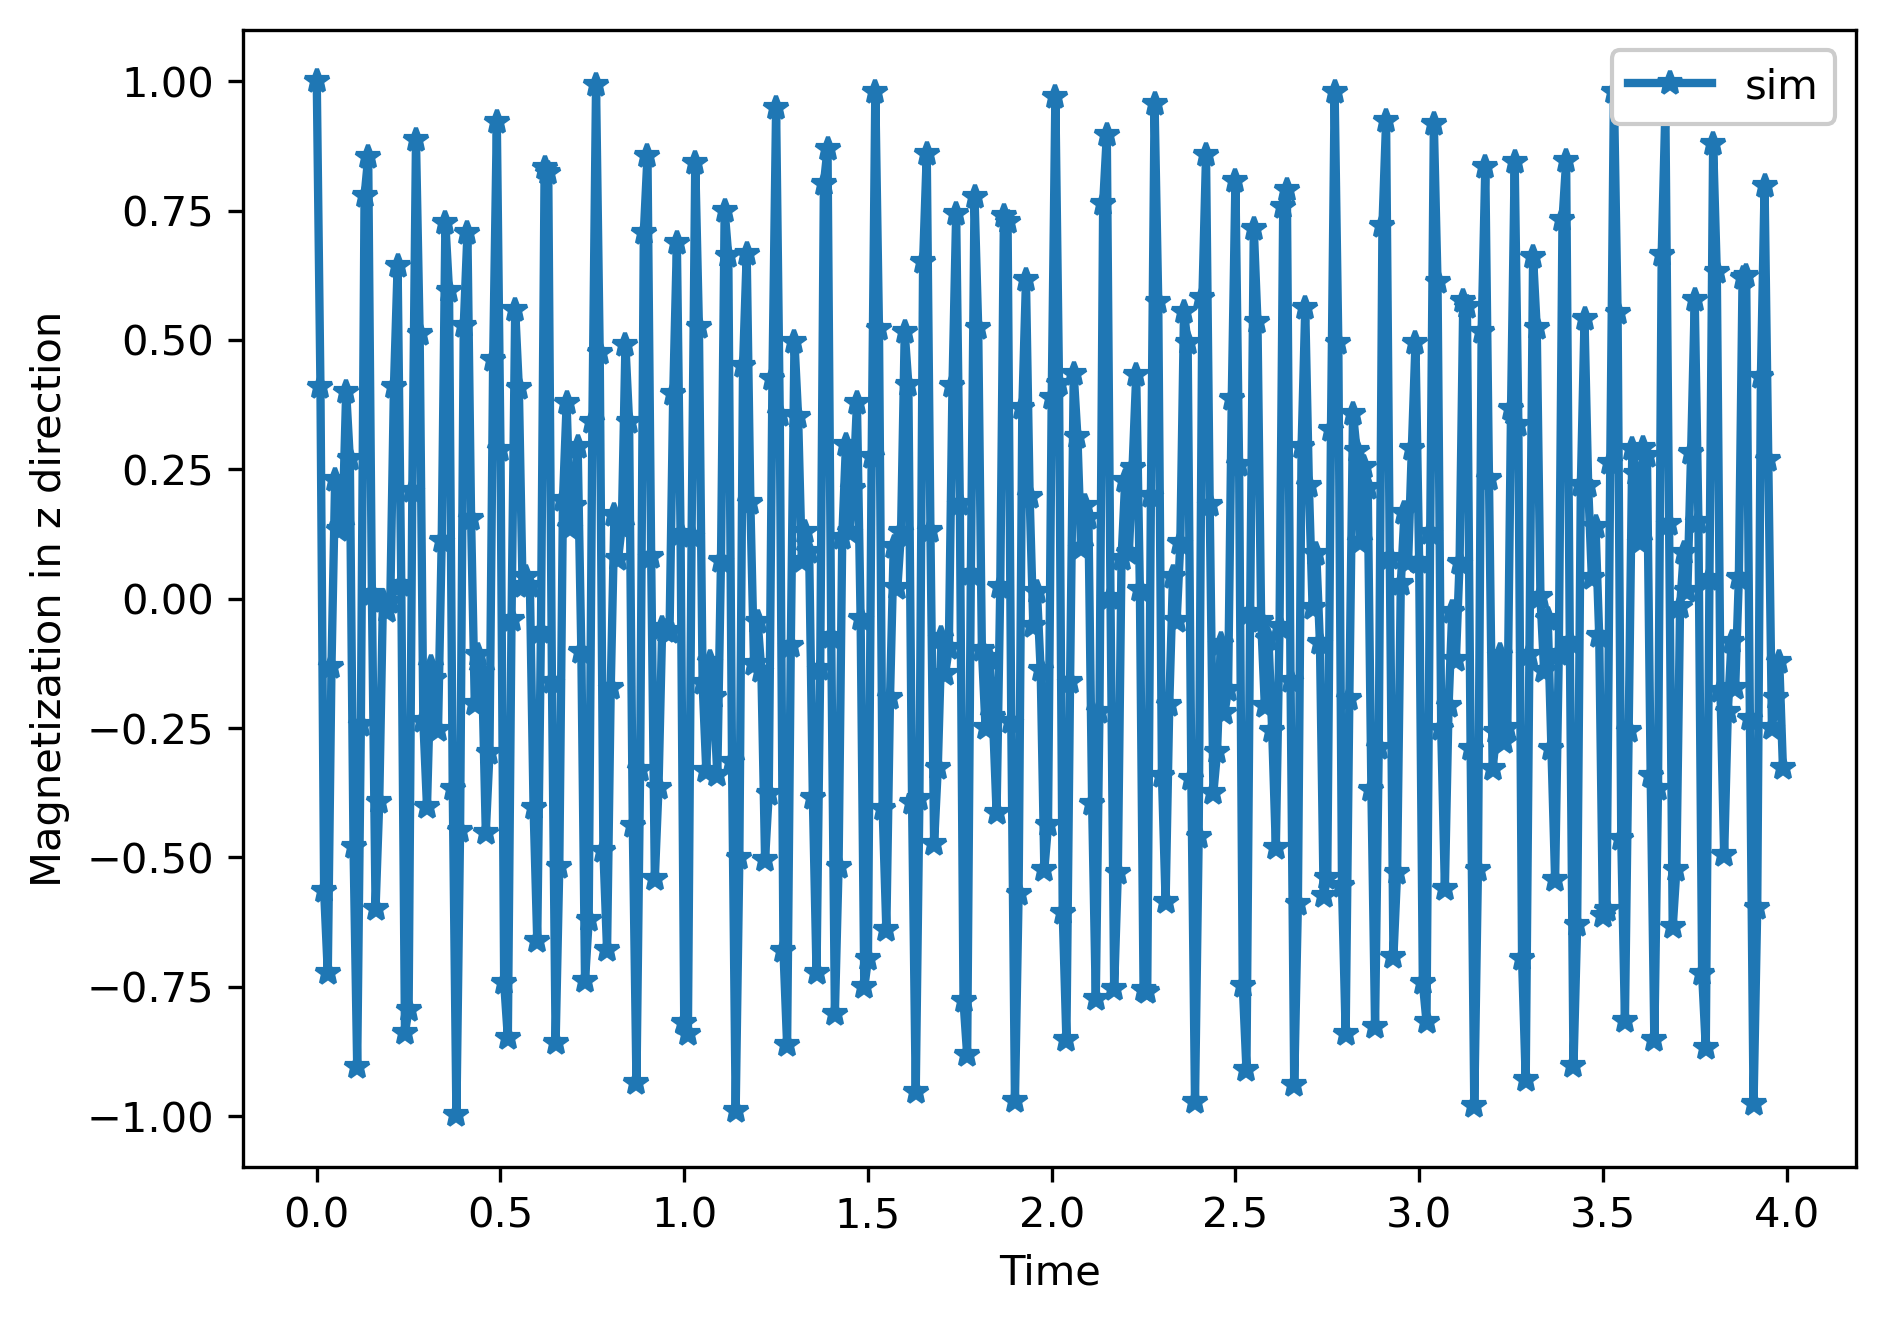

In [10]:
import matplotlib.pyplot as plt

plt.figure(dpi=300)

plt.plot(times, m_avg_z, color="C0", marker="*", lw=2.0, label="sim")

plt.xlabel("Time", fontsize=10)
plt.ylabel("Magnetization in z direction", fontsize=10)
plt.legend(loc="upper right", fontsize=10, framealpha=1.0)


plt.subplots_adjust(left=0.15, right=0.99, top=0.95, bottom=0.16)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Step 4: Finding the Spectrum

In this step, we perform a fourier transform of the correlation functions to find the spectrum. 

$$ A(\omega)=\text{Re}\left\{\int_{0}^{\infty}~dt~e^{-i\omega t-\Gamma t}\text{Tr}\{S^z_{\rm tot}(t)S^z_{\rm tot}\}+i\int_{0}^{\infty}~dt~e^{-i\omega t-\Gamma t}\text{Tr}\{S^y_{\rm tot}(t)S^z_{\rm tot}\}\right\},$$

where $\Gamma$ is the effective decoherence rate that physically arises due to the interaction of nuclear spin with its environment or simply an artificial decay to perform the Fourier transform.

In [11]:
from scipy import sparse, integrate

time = np.linspace(0, number_of_trottersteps * trotter_timestep, number_of_trottersteps)

w_max = 0.5 / trotter_timestep
frequencies = np.linspace(-w_max, w_max, number_of_trottersteps)


spectrum_full = []

gamma = 2.0

for w in frequencies:
    integrand_z = np.multiply(
        np.exp(1j * (-2.0 * np.pi * w * time) - gamma * time), m_avg_z
    )
    integrand_y = np.multiply(
        np.exp(1j * (-2.0 * np.pi * w * time) - gamma * time), m_avg_y
    )

    integral_z = integrate.cumulative_trapezoid(integrand_z, time, initial=0)
    integral_y = integrate.cumulative_trapezoid(integrand_y, time, initial=0)

    spectrum_full.append(
        integral_z.real[number_of_trottersteps - 1]
        - integral_y.imag[number_of_trottersteps - 1]
    )

In [12]:
G_ratio = 267522128.0  # Gyromagnetic_ratio of 1H in rad/(s*T)
z = (
    -1565014368.5806985
)  # mean value of orinal energies that has been substracted from energies
B_field = 11.7  # magnetic field in Tesla


Hz_in_ppm = 2.0 * np.pi / (G_ratio * B_field) * 1e6

# the chemical shift:
chem_shift = 2 * z / (1e-6 * G_ratio * B_field) + 1e6

# to have the frequency axis in ppm:
ppm = (frequencies) * Hz_in_ppm - chem_shift

norm_me = integrate.simpson(spectrum_full, ppm)

spectrum_full_new = []

for value in spectrum_full:
    value_new = value / norm_me
    spectrum_full_new.append(value_new)

Reading off the known spectrum obtained via exact diagonalization from json file. You can also use `HQS Spectrum Tools` to calculate the spectrum.

In [13]:
import json

with open("2qubit_ppm_direct_cis_3_chloroacrylic_acid_B=11.7_Tesla.json", "r") as f:
    ppm_direct = json.load(f)
with open(
    "2qubit_spectrum_direct_cis_3_chloroacrylic_acid_B=11.7_Tesla.json", "r"
) as f:
    spectrum_direct = json.load(f)

Comparing the simulated spectrum with known results.

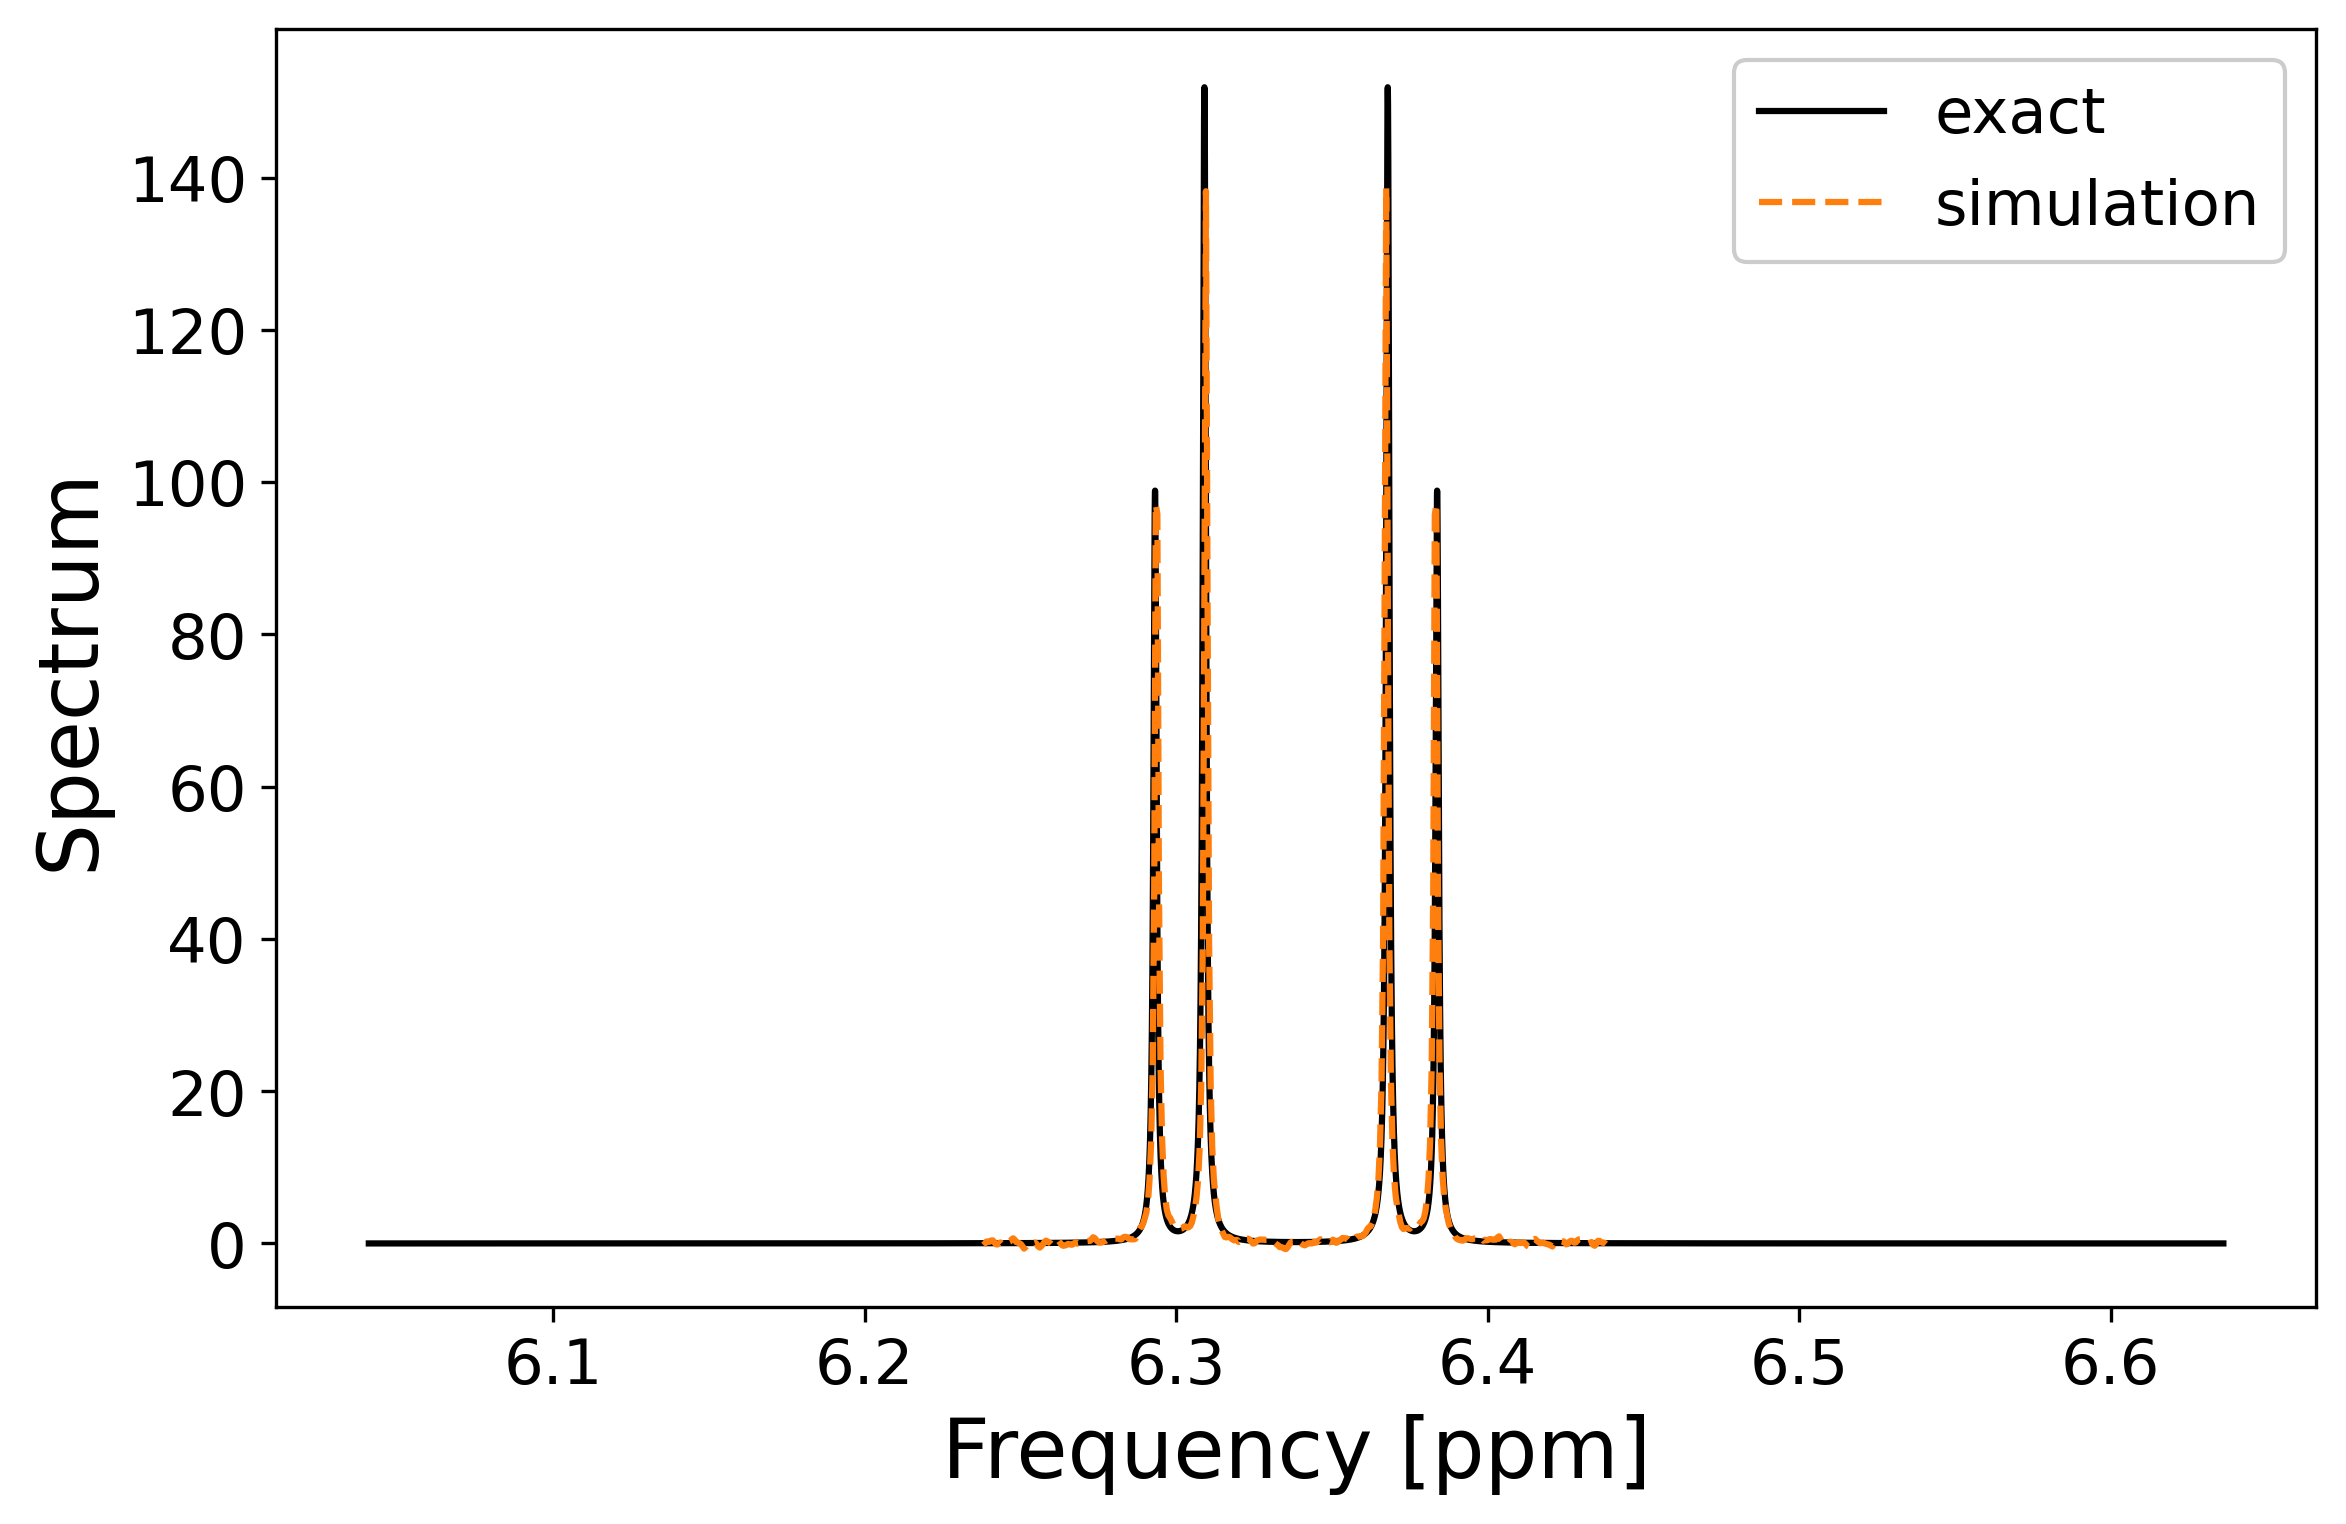

In [14]:
plt.figure(dpi=300, figsize=(10, 6))

plt.plot(ppm_direct, spectrum_direct, "k-", ms=5, label="exact")
plt.plot(ppm, spectrum_full_new, "C1--", ms=5, label="simulation")


plt.xlabel("Frequency [ppm]", fontsize=20)
plt.ylabel("Spectrum", fontsize=20)


plt.subplots_adjust(left=0.15, right=0.99, top=0.95, bottom=0.16)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc="upper right", fontsize=15, framealpha=1.0)
plt.subplots_adjust(left=0.22, right=0.90, top=0.90, bottom=0.19)

plt.show()